## Importar librerias

# 🎯 Sistema de Predicción de Uso de Biblioteca Universitaria

## Proyecto: IA_Library_Proyect

### 📋 Resumen Ejecutivo

Este proyecto desarrolla un **sistema inteligente de predicción** para el uso diario de la biblioteca de la Universidad de Concepción (UDEC), utilizando técnicas avanzadas de Machine Learning y análisis de series temporales.

### 🎯 Objetivos del Proyecto

1. **Objetivo Principal**: Predecir el número de accesos diarios a la biblioteca universitaria
2. **Objetivo Secundario**: Optimizar la gestión de recursos y mejorar la experiencia del usuario
3. **Objetivo Técnico**: Implementar un modelo robusto con validación temporal rigurosa

### 🔍 Problemática Identificada

- **Gestión de Recursos**: Dificultad para planificar personal y espacios sin predicción
- **Experiencia Usuario**: Incertidumbre sobre ocupación y disponibilidad
- **Toma de Decisiones**: Falta de información predictiva para optimización
- **Variabilidad Temporal**: Patrones complejos universitarios (semestres, certámenes, vacaciones)

### 🚀 Solución Propuesta

**Sistema de Machine Learning** con:
- ✅ Ingeniería de características avanzada (6 → 19 variables)
- ✅ Modelos comparativos (Random Forest vs XGBoost)
- ✅ Validación temporal sin data leakage
- ✅ Data augmentation para datasets pequeños
- ✅ Interpretabilidad y análisis de importancia

In [2]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.19.0
- Version scikit-learn: 1.7.2
- Version pandas: 2.2.3
- Version numpy: 2.2.6


## Funciones de utilidad

In [3]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

## Lectura del dataset

## 📊 Dataset y Fuentes de Datos

### 🗂️ Datos Principales
- **Archivo**: `accesos.xlsx` - Registros históricos individuales de acceso
- **Período**: ~500 días de actividad universitaria
- **Granularidad**: Datos agregados por día para análisis temporal
- **Variables originales**: Fecha, Hora, Jornada, Pregrado, Postgrado

### 🗂️ Datos Auxiliares
- **Archivo**: `dias_vacaciones.txt` - Calendario académico oficial
- **Propósito**: Variable exógena para contexto institucional
- **Impacto**: Identificación de períodos no lectivos

### 🔧 Justificación del Enriquecimiento del Dataset

**¿Por qué fue necesario enriquecer tanto el dataset?**

El dataset original tenía **limitaciones críticas**:
- ❌ Solo 6 columnas básicas (insuficiente para patrones complejos)
- ❌ Algoritmos ML no entienden naturalmente patrones temporales
- ❌ Pérdida de información estacional universitaria
- ❌ Ruido en datos diarios sin suavizado
- ❌ Ausencia de dependencias temporales explícitas

**Solución implementada**:
- ✅ **13 nuevas variables** especializadas
- ✅ **316% más información** (6 → 19 columnas)
- ✅ **Múltiples perspectivas temporales** (corto, mediano, largo plazo)
- ✅ **Contexto académico específico** (semestres, certámenes)

In [4]:
try:
    daily_counts_full = pd.read_csv("Datasets/accesos_biblioteca.csv")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'daily_counts_full.csv'")
    exit(1)

In [5]:
print("Dataset original - Columnas iniciales:")
print(f"Columnas: {list(daily_counts_full.columns)}")
print(f"Forma del dataset: {daily_counts_full.shape}")
print("\nPrimeras 3 filas:")
print(daily_counts_full.head(3))

Dataset original - Columnas iniciales:
Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Semestre', 'Accesos', 'Vacaciones?']
Forma del dataset: (511, 7)

Primeras 3 filas:
        Fecha  Día  Mes   Año  Semestre  Accesos  Vacaciones?
0  2023-12-14   14   12  2023         2      953            0
1  2023-12-15   15   12  2023         2      549            0
2  2023-12-16   16   12  2023         2       71            0


In [6]:
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Mes', 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])

daily_counts_full.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,mes_sin,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30
433,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,0.5,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866
434,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,0.5,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520
435,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,0.5,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938
436,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,0.5,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296
437,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,0.5,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697


## Semestres

In [7]:
# Crear variable de semestre: 1 para marzo-julio, 2 para agosto-diciembre, 0 para otros meses
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)

daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)

daily_counts_full.head(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,mes_sin,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30
0,2023-12-14,14,12,2023,2,953,0,NaN,NaN,NaN,-2.449294e-16,1.0,0.433884,-0.900969,NaN,NaN,NaN
1,2023-12-15,15,12,2023,2,549,0,953.000000,953.000000,953.000000,-2.449294e-16,1.0,-0.433884,-0.900969,953.0000,953.000000,953.000000
2,2023-12-16,16,12,2023,2,71,0,751.000000,751.000000,751.000000,-2.449294e-16,1.0,-0.974928,-0.222521,852.0000,899.133333,926.935484
3,2023-12-18,18,12,2023,2,739,0,524.333333,524.333333,524.333333,-2.449294e-16,1.0,0.000000,1.000000,656.7500,788.715556,871.713840
4,2023-12-19,19,12,2023,2,383,0,578.000000,578.000000,578.000000,-2.449294e-16,1.0,0.781831,0.623490,677.3125,782.086815,863.151657


## Semanas de certamen

In [8]:
# Calcular la semana dentro del semestre
def semana_en_semestre(row):
    # Primer semestre: marzo (3) a julio (7)
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    # Segundo semestre: agosto (8) a diciembre (12)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])

daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full.tail(5)


,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,mes_sin,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre
433,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,0.5,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9.0
434,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,0.5,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10.0
435,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,0.5,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10.0
436,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,0.5,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10.0
437,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,0.5,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10.0


## Semana con mayor afluencia

In [9]:
# Agrupar por año, semestre y semana del semestre
semanas_semestre_mayor_ingreso = (
    daily_counts_full
    .groupby(['Año', 'Semestre', 'Semana_Semestre'])['Accesos']
    .sum()
    .reset_index()
    .sort_values('Accesos', ascending=False)
)

print(semanas_semestre_mayor_ingreso.head(10))
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)

     Año  Semestre  Semana_Semestre  Accesos
52  2025         1              6.0    19880
9   2024         1              7.0    19514
10  2024         1              8.0    18971
12  2024         1             10.0    17367
51  2025         1              5.0    17003
15  2024         1             13.0    16199
8   2024         1              6.0    16073
34  2024         2             10.0    15865
42  2024         2             18.0    15219
33  2024         2              9.0    15140


## Resumen de Ingeniería de Características

A continuación se muestran todas las **nuevas columnas** creadas a partir del dataset original:

In [10]:
print("=== NUEVAS COLUMNAS CREADAS POR INGENIERÍA DE CARACTERÍSTICAS ===\n")

# Columnas originales del dataset base
columnas_originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']

# Mostrar todas las columnas actuales
columnas_actuales = list(daily_counts_full.columns)
nuevas_columnas = [col for col in columnas_actuales if col not in columnas_originales]

print("📊 DATASET ORIGINAL:")
print(f"   Columnas: {columnas_originales}")
print(f"   Total: {len(columnas_originales)} columnas\n")

print("🔧 NUEVAS COLUMNAS AGREGADAS:")
for i, col in enumerate(nuevas_columnas, 1):
    print(f"   {i:2d}. {col}")

print(f"\n📈 RESUMEN:")
print(f"   • Columnas originales: {len(columnas_originales)}")
print(f"   • Nuevas columnas: {len(nuevas_columnas)}")
print(f"   • Total final: {len(columnas_actuales)} columnas")
print(f"   • Shape del dataset: {daily_counts_full.shape}")

print(f"\n🎯 CATEGORÍAS DE NUEVAS CARACTERÍSTICAS:")
print("   • Variables de tendencia: media_movil_7, media_movil_14, media_movil_30")
print("   • Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos") 
print("   • Medias exponenciales: ewma_7, ewma_14, ewma_30")
print("   • Variables académicas: Semestre, Semana_Semestre, Semana_Certamen")
print("   • Variables lag: lag_7, lag_14, lag_21 (se agregarán después)")

# Mostrar una muestra del dataset con las nuevas columnas
print("\n📋 MUESTRA DEL DATASET CON NUEVAS COLUMNAS:")
print(daily_counts_full[['Fecha', 'Accesos'] + nuevas_columnas[:5]].head(3))

=== NUEVAS COLUMNAS CREADAS POR INGENIERÍA DE CARACTERÍSTICAS ===

📊 DATASET ORIGINAL:
   Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
   Total: 6 columnas

🔧 NUEVAS COLUMNAS AGREGADAS:
    1. Semestre
    2. Vacaciones?
    3. media_movil_7
    4. media_movil_14
    5. media_movil_30
    6. mes_sin
    7. mes_cos
    8. dia_semana_sin
    9. dia_semana_cos
   10. ewma_7
   11. ewma_14
   12. ewma_30
   13. Semana_Semestre
   14. Semana_Certamen

📈 RESUMEN:
   • Columnas originales: 6
   • Nuevas columnas: 14
   • Total final: 19 columnas
   • Shape del dataset: (438, 19)

🎯 CATEGORÍAS DE NUEVAS CARACTERÍSTICAS:
   • Variables de tendencia: media_movil_7, media_movil_14, media_movil_30
   • Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos
   • Medias exponenciales: ewma_7, ewma_14, ewma_30
   • Variables académicas: Semestre, Semana_Semestre, Semana_Certamen
   • Variables lag: lag_7, lag_14, lag_21 (se agregarán después)

📋 MUESTRA DEL DATASET 

## Grafico del Dataset

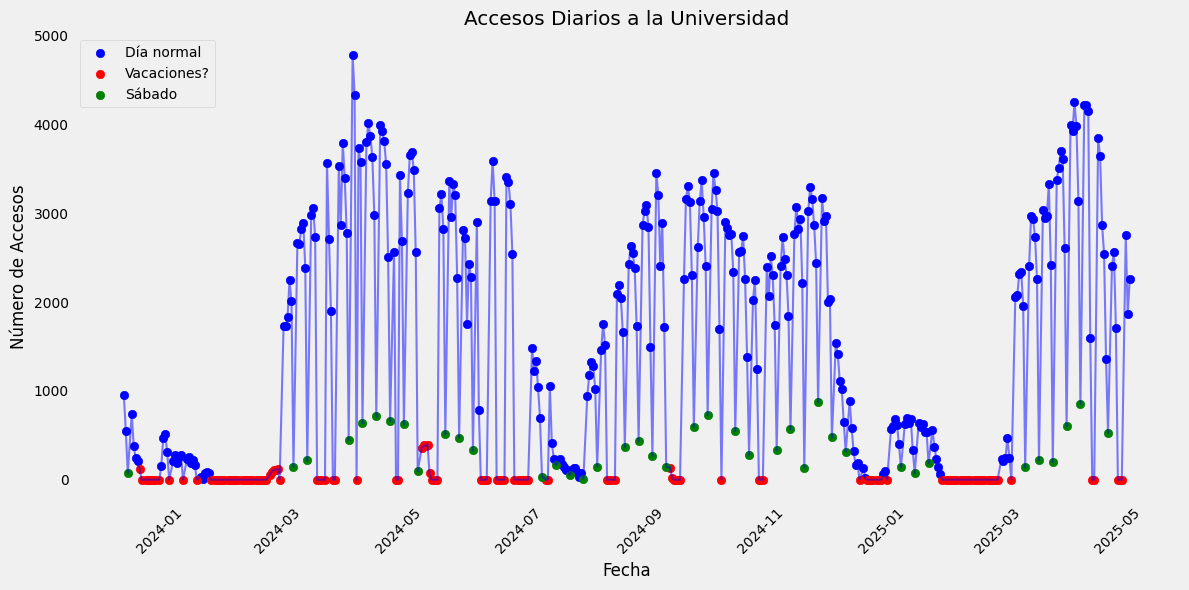

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(daily_counts_full['Fecha'], daily_counts_full['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (daily_counts_full['Vacaciones?'] == 0) & (daily_counts_full['Fecha'].dt.weekday != 5)
plt.scatter(daily_counts_full['Fecha'][no_vac_no_sab], daily_counts_full['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (daily_counts_full['Vacaciones?'] == 1)
plt.scatter(daily_counts_full['Fecha'][vac], daily_counts_full['Accesos'][vac], color='r', label='Vacaciones?')

# Puntos de sábados
sab = (daily_counts_full['Vacaciones?'] == 0) & (daily_counts_full['Fecha'].dt.weekday == 5)
plt.scatter(daily_counts_full['Fecha'][sab], daily_counts_full['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## División de datos de entrenamiento y test


In [ ]:
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])

daily_counts_full = daily_counts_full.dropna().reset_index(drop=True)

X = daily_counts_full[['Día', 'Mes', 'Año', 'Semestre', 'Vacaciones?', 
                      'Semana_Semestre', 'Semana_Certamen',
                      'media_movil_7', 'media_movil_14', 'media_movil_30', 
                      'ewma_7', 'ewma_14', 'ewma_30', 
                      'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
                      'lag_7', 'lag_14', 'lag_21']]

y = daily_counts_full['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
y = daily_counts_full['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 256
Datos de prueba: 64


In [13]:
print("=== DATASET FINAL DESPUÉS DE INGENIERÍA DE CARACTERÍSTICAS ===\n")

# Mostrar todas las columnas finales organizadas por categoría
print("📊 COLUMNAS ORGANIZADAS POR CATEGORÍA:")

print("\n🔹 Variables originales:")
originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
for col in originales:
    if col in daily_counts_full.columns:
        print(f"   • {col}")

print("\n🔹 Variables de tendencia/suavizado:")
tendencia = [col for col in daily_counts_full.columns if 'media_movil' in col or 'ewma' in col]
for col in tendencia:
    print(f"   • {col}")

print("\n🔹 Variables cíclicas/temporales:")
ciclicas = [col for col in daily_counts_full.columns if any(x in col for x in ['sin', 'cos'])]
for col in ciclicas:
    print(f"   • {col}")

print("\n🔹 Variables del contexto académico:")
academicas = [col for col in daily_counts_full.columns if any(x in col for x in ['Semestre', 'Semana', 'Certamen'])]
for col in academicas:
    print(f"   • {col}")

print("\n🔹 Variables lag (retardos temporales):")
lags = [col for col in daily_counts_full.columns if 'lag_' in col]
for col in lags:
    print(f"   • {col}")

print(f"\n📈 RESUMEN FINAL:")
print(f"   • Total de columnas: {len(daily_counts_full.columns)}")
print(f"   • Filas en el dataset: {len(daily_counts_full)}")
print(f"   • Nuevas características creadas: {len(daily_counts_full.columns) - 6}")  # 6 son las originales

=== DATASET FINAL DESPUÉS DE INGENIERÍA DE CARACTERÍSTICAS ===

📊 COLUMNAS ORGANIZADAS POR CATEGORÍA:

🔹 Variables originales:
   • Fecha
   • Día
   • Mes
   • Año
   • Accesos

🔹 Variables de tendencia/suavizado:
   • media_movil_7
   • media_movil_14
   • media_movil_30
   • ewma_7
   • ewma_14
   • ewma_30

🔹 Variables cíclicas/temporales:
   • mes_sin
   • mes_cos
   • dia_semana_sin
   • dia_semana_cos

🔹 Variables del contexto académico:
   • Semestre
   • Semana_Semestre
   • Semana_Certamen

🔹 Variables lag (retardos temporales):
   • lag_7
   • lag_14
   • lag_21

📈 RESUMEN FINAL:
   • Total de columnas: 22
   • Filas en el dataset: 320
   • Nuevas características creadas: 16


## Data Augmentation

In [17]:
X_train_aug = [X_train.copy()]
y_train_aug = [y_train.copy()]
N_AUGMENTATIONS = 4

for i in range(N_AUGMENTATIONS):
    if i % 2 == 0:
        y_new = y_train * np.random.uniform(0.95, 1.05)
    else:
        y_new = y_train + np.random.normal(0, y_train.std() * 0.02, len(y_train))
    
    df_new = X_train.copy()
    df_new['Accesos'] = y_new

    df_new = agregar_lags(df_new, 'Accesos', [7,14,21])
    df_new = agregar_medias_moviles(df_new, 'Accesos', [7,14,30])
    df_new = agregar_ewma(df_new, 'Accesos', [7,14,30])

    df_new = df_new.dropna().reset_index(drop=True)
    
    X_train_aug.append(df_new[X_train.columns])
    y_train_aug.append(df_new['Accesos'])

X_train_final = pd.concat(X_train_aug)
y_train_final = pd.concat(y_train_aug)

print(f"Tamaño final del set de entrenamiento: {len(X_train_final)} muestras.")
df_new.tail(5)

Tamaño final del set de entrenamiento: 1196 muestras.


,Día,Mes,Año,Semestre,Vacaciones?,Semana_Semestre,Semana_Certamen,media_movil_7,media_movil_14,media_movil_30,...,ewma_14,ewma_30,mes_sin,mes_cos,dia_semana_sin,dia_semana_cos,lag_7,lag_14,lag_21,Accesos
230,19,12,2024,2,0,21.0,0,698.290782,1298.320471,1855.194653,...,1124.679646,1540.426453,-2.449294e-16,1.0,0.433884,-0.900969,1112.750763,2865.538758,3030.276295,219.915144
231,20,12,2024,2,0,21.0,0,570.742837,1109.347355,1786.308078,...,1004.044379,1455.232175,-2.449294e-16,1.0,-0.433884,-0.900969,1051.095537,2945.362393,3286.748021,203.902730
232,21,12,2024,2,1,21.0,0,449.715293,913.528808,1730.874003,...,897.358826,1374.501243,-2.449294e-16,1.0,-0.974928,-0.222521,647.327247,2014.776797,3141.572439,-24.280421
233,23,12,2024,2,0,21.0,0,353.771340,767.881864,1712.038697,...,774.473593,1284.257265,-2.449294e-16,1.0,0.000000,1.000000,292.204428,2071.596023,2859.661161,117.261686
234,24,12,2024,2,0,21.0,0,328.779520,628.286554,1623.822057,...,686.845339,1208.967227,-2.449294e-16,1.0,0.781831,0.623490,862.024903,441.385572,2410.890306,13.001268


## Crear modelo


In [21]:
if "modelo_RandomForest.pkl" not in os.listdir('Archivos Auxiliares'):
    print("Entrenando el modelo Random Forest")
    X_train_final = X_train_final[X_test.columns]
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 8, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train_final, y_train_final)
    print(f'Mejores parámetros: {grid_search.best_params_}')

    best_params = grid_search.best_params_
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train_final, y_train_final)
    joblib.dump(model, 'Archivos Auxiliares/modelo_RandomForest.pkl')
    print("Modelo guardado como 'Archivos Auxiliares/modelo_RandomForest.pkl'")
else:
    model = joblib.load('Archivos Auxiliares/modelo_RandomForest.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares/modelo_RandomForest.pkl'")

Modelo cargado desde 'Archivos Auxiliares/modelo_RandomForest.pkl'


## Evaluación de rendimiento

In [23]:
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Semana_Certamen
- Semana_Semestre
- Semestre
- dia_semana_cos
- dia_semana_sin
- ...


NameError: name 'predicted' is not defined

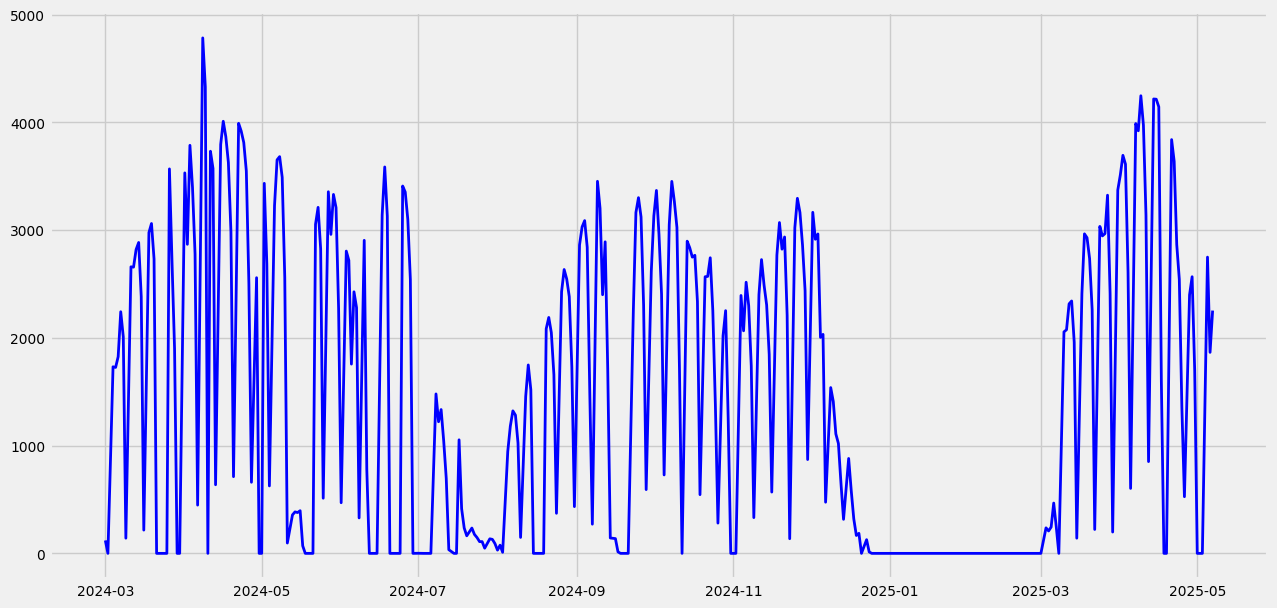

In [24]:
fechas = daily_counts_full['Fecha']
plt.figure(figsize=(14, 7))
plt.plot(fechas, daily_counts_full['Accesos'], label='Datos reales (train + test)', color='blue', linewidth=2)
plt.plot(fechas.loc[X_test.index], predicted, label='Predicción (test)', color='red', linestyle='--', linewidth=2)
plt.title('Accesos reales y predicción en el test', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

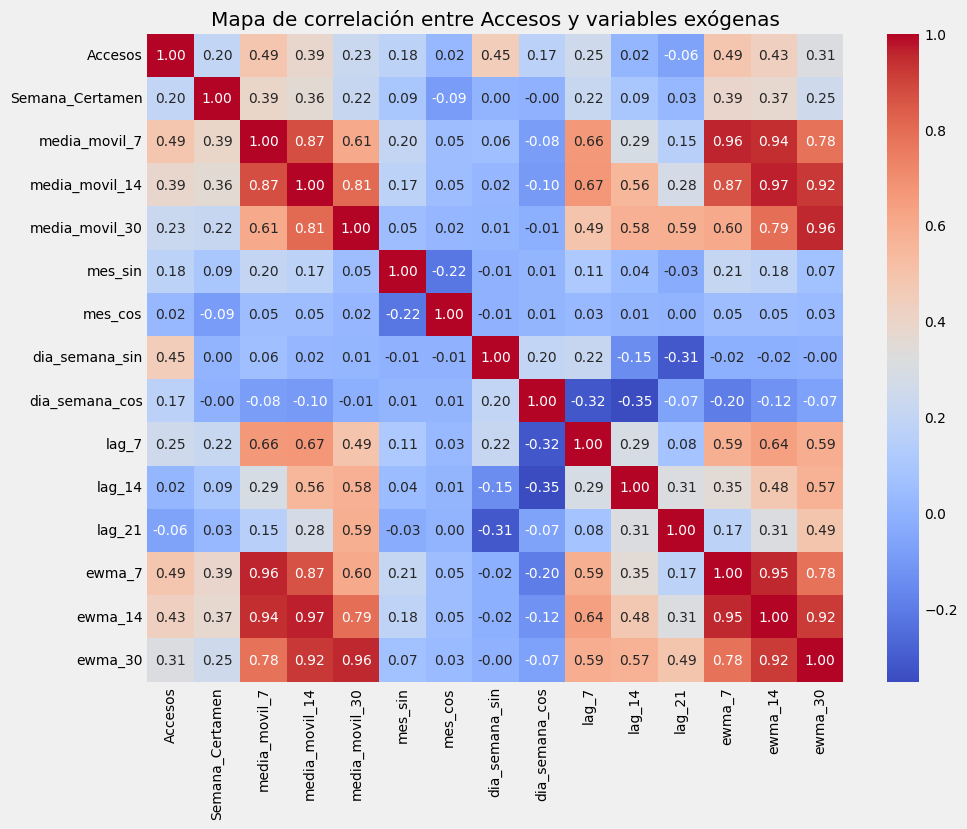

In [ ]:
corr_df = daily_counts_full[['Accesos', 'Semana_Certamen','media_movil_7','media_movil_14','media_movil_30',
                      'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos','lag_7', 'lag_14', 'lag_21','ewma_7','ewma_14','ewma_30']].copy()

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de correlación entre Accesos y variables exógenas')
plt.show()

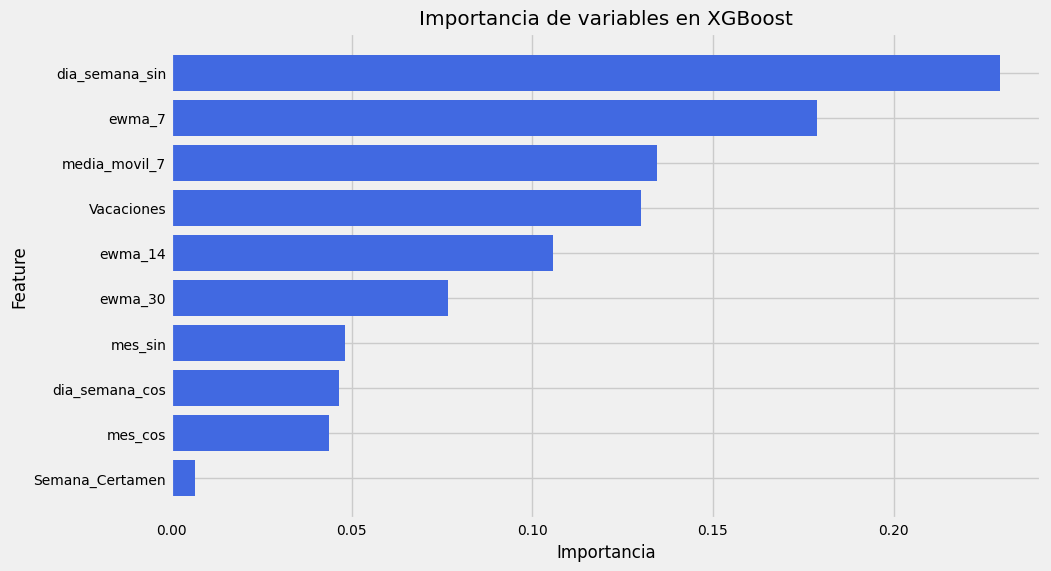

In [ ]:
importances = model.feature_importances_

features = X_train_final.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='royalblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en XGBoost")
plt.gca().invert_yaxis() 
plt.show()

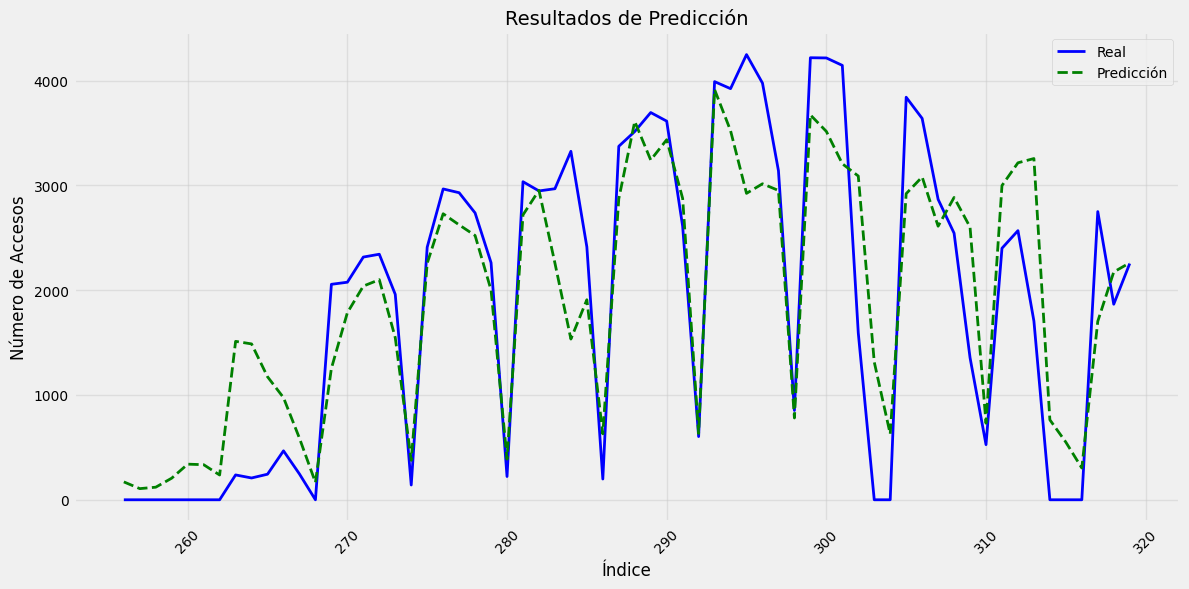

In [ ]:
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='green', linestyle='--', linewidth=2)
plt.title('Resultados de Predicción', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()